# Исследование надежности заемщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

1. [Обзор данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка пропущенных значений](#null)
    * [Изменение типов данных](#types)
    * [Обработка дубликатов](#duplicates)
    * [Лемматизация](#lemmas)
    * [Артефакты](#strange)
    * [Категоризация](#categories)
    
3. [Выводы](#summary)

# Обзор данных<a id="start"></a>

Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.stem import SnowballStemmer

Загрузим данные и посмотрим на первые строки датасета:

In [2]:
data = pd.read_csv('bank_data.csv')
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Сразу бросаются в глаза некоторые странности. Как трудовой стаж может быть отрицательным? 340266 дней трудового стажа - нереальная цифра. (Может быть, это в часах?) С этим нужно будет разобраться.

Оценим количество данных в датасете, посмотрим, есть ли в нем пропуски, и выясним, к каким типам относятся данные в разных столбцах:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


- В столбцах days_employed и total_income есть пропуски (причем их одинаковое количество).
- Цифры в этих столбцах стоит привести к целочисленному виду для удобства работы.

# Предобработка данных<a id="preprocessing"></a>

Постараемся избавиться от ошибок в данных и сделать их максимально удобными для дальнейшей работы.

## Обработка пропущенных значений<a id='null'></a>

Мы уже выяснили, что пропуски есть в столбцах с трудовым стажем и доходом. Посмотрим, сколько их:

In [4]:
print('В столбце с трудовым стажем пропущено {:.1%} данных.'.format(data['days_employed'].isna().sum() / len(data)))

В столбце с трудовым стажем пропущено 10.1% данных.


Мы также заметили, что в этих двух столбцах одинаковое количество пропусков:

In [5]:
data[data['days_employed'].isna() == True]['total_income'].sum()

0.0

У одних и тех же клиентов отсутствуют данные о трудовом стаже и о доходе. И таких 10%. А что у этих клиентов с данными в интересующих нас столбцах: семейное положение, количество детей, возврат кредита?

In [6]:
data[data['days_employed'].isna() == True]['family_status'].value_counts()

женат / замужем          1237
гражданский брак          442
Не женат / не замужем     288
в разводе                 112
вдовец / вдова             95
Name: family_status, dtype: int64

In [7]:
data[data['days_employed'].isna() == True]['children'].value_counts()

 0     1439
 1      475
 2      204
 3       36
 20       9
 4        7
-1        3
 5        1
Name: children, dtype: int64

In [8]:
data[data['days_employed'].isna() == True]['debt'].value_counts()

0    2004
1     170
Name: debt, dtype: int64

Данные, которые интересуют нас в первую очередь в рамках текущей задачи, на месте. Поэтому не будем удалять строки с отсутствующими значениями по трудовому стажу и доходу. Не будем и заменять их средним арифметическим или медианным значением, чтобы они не влияли на точность наших выводов в будущем. Лучше заменим пропуски нулями:

In [9]:
data['days_employed'] = data['days_employed'].fillna(0)
data['total_income'] = data['total_income'].fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Изменение типов данных<a id = 'types'></a>

Изменим типы данных в столбцах days_employed и total_income; для удобства приведем их к целым числам:

In [10]:
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int32 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int32 
 11  purpose           21525 non-null  object
dtypes: int32(2), int64(5), object(5)
memory usage: 1.8+ MB


## Обработка дубликатов <a id = 'duplicates'></a>

Уже при первичном обзоре данных были заметны проблемы с регистром в столбце с образованием:

In [11]:
data['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Чтобы оценить распределение заемщиков по уровню образования, нужно избавиться от дубликатов:

In [12]:
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Теперь видно, что в нашем датасете преобладают клиенты со средним образованием. Людей с высшим образованием втрое меньше.

Проверим: может быть, аналогичная проблема есть и в других столбцах с текстовыми значениями?

In [13]:
data['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

Здесь разница в регистре ни на что не влияет, но унифицируем внешний вид данных, чтобы они выглядели аккуратнее:

In [14]:
data['family_status'] = data['family_status'].str.lower()
data['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [15]:
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

Одно непонятное значение ни на что не влияет. Но лучше удалим его для удобства работы:

In [16]:
data[data['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости


In [17]:
data.drop([10701], inplace = True)
data['gender'].value_counts()

F    14236
M     7288
Name: gender, dtype: int64

In [18]:
data['income_type'].value_counts()

сотрудник          11119
компаньон           5084
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

Здесь нет дублей, но стоит уточнить у заказчика, что понимается под "компаньоном"; похоже, это слово используется не в своем прямом значении, что может привести к ошибкам при анализе данных.

Для задач кредитного скоринга может понадобиться выделить в две отдельные группы работающих и безработных клиентов. Но наша текущая задача этого не требует.

## Лемматизация<a id = 'lemmas'></a>

Данные в последнем столбце (с целями кредита) требуют особого подхода:

In [19]:
data.purpose.value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      623
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Одни и те же цели кредита записаны по-разному. С информацией, представленной в таком виде, работать неудобно. Нужно привести значения к общему знаменателю и понять, какое на самом деле распределение по целям кредита в нашем датасете.

В нашем случае беглый просмотр таблицы, представленной выше, позволяет выделить 4 основных цели. Напишем простую функцию и применим ее к столбцу с целями кредита, сохранив результат в новый столбец purpose_type.

In [20]:
def purpose_type(purpose):
    if 'образ' in purpose:
        return 'образование'
    elif 'недвиж' in purpose or 'жил' in purpose:
        return 'недвижимость'
    elif 'свадьб' in purpose:
        return 'свадьба'
    elif 'авто' in purpose:
        return 'автомобиль'

In [21]:
data['purpose_type'] = data['purpose'].apply(purpose_type)
data.purpose_type.value_counts()

недвижимость    10839
автомобиль       4315
образование      4022
свадьба          2348
Name: purpose_type, dtype: int64

Так намного понятнее. В основном люди берут кредиты для покупки или ремонта недвижимости, реже - для покупки автомобиля, получения образования или проведения свадьбы.

Если вариантов слишком много, чтобы выделить основные цели "на глазок", можно использовать стемминг или лемматизацию. Сохраним словоформы в отдельный столбец lemmas:

In [22]:
russian_stemmer = SnowballStemmer('russian')

def lemmas(purpose):
    lemmas = []
    for word in purpose.split():
        stemmed_word = russian_stemmer.stem(word)
        lemmas.append(stemmed_word)
    return lemmas

data['lemmas'] = data['purpose'].apply(lemmas)
data.head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_type,lemmas
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость,"[покупк, жил]"
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,"[приобретен, автомобил]"
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость,"[покупк, жил]"


Теперь соберем все значения в столбце lemmas в отдельный список и посчитаем, как часто встречается каждая словоформа:

In [23]:
lemmas_list = []
for lst in data.lemmas:
    for lemma in lst:
        lemmas_list.append(lemma)

lemmas_list = list(Counter(lemmas_list).items())
lemmas_list.sort(key = lambda i: i[1], reverse = True)
lemmas_list

[('недвижим', 6366),
 ('покупк', 5911),
 ('жил', 5706),
 ('образован', 4022),
 ('автомобил', 3837),
 ('с', 2924),
 ('операц', 2610),
 ('свадьб', 2348),
 ('сво', 2235),
 ('на', 2233),
 ('строительств', 1881),
 ('высш', 1375),
 ('получен', 1316),
 ('коммерческ', 1315),
 ('для', 1294),
 ('подержа', 968),
 ('сделк', 944),
 ('дополнительн', 909),
 ('заня', 908),
 ('проведен', 777),
 ('сыгра', 774),
 ('сдач', 653),
 ('сем', 641),
 ('собствен', 635),
 ('со', 630),
 ('ремонт', 612),
 ('автомоб', 478),
 ('приобретен', 462),
 ('профильн', 436)]

Возможно, операции с коммерческой недвижимостью и ремонт жилья стоит выделить в отдельные подкатегории. Все зависит от целей. 

Пока оставим нашу разбивку по целям как есть, только зашифруем текстовые значения в числовые категории в отдельном столбце (по аналогии с education_id и family_status_id) для удобства дальнейшей работы.

In [24]:
data['purpose_id'] = data['purpose_type'].replace({'недвижимость': 1, 'автомобиль': 2, 'образование': 3, 'свадьба': 4})
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_type,lemmas,purpose_id
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,недвижимость,"[покупк, жил]",1
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,"[приобретен, автомобил]",2
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,недвижимость,"[покупк, жил]",1
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,"[дополнительн, образован]",3
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,"[сыгра, свадьб]",4


## Артефакты<a id='strange'></a>

В датасете встречаются артефакты - странные значения, не отражающие действительность. Обработаем их, чтобы они не мешали анализировать данные:

In [25]:
data.children.value_counts()

 0     14148
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Кажется, -1 и 20 - это опечатки. Вероятно, имелось в виду 1 и 2, соответственно, но уверенности у нас нет. Поскольку количество таких данных невелико, мы можем либо удалить эти строки, либо исправить их. Поскольку цель нашего анализа - узнать, связаны ли семейный статус и количество детей с надежностью заемщика, лучше избежать неточных значений в этом столбце. Лучше удалим их:

In [26]:
data.drop(data[(data['children'] == -1) | (data['children'] == 20)].index, inplace = True)
data.children.value_counts()

0    14148
1     4818
2     2055
3      330
4       41
5        9
Name: children, dtype: int64

Посмотрим, как распределены данные в столбце с доходом. Исключим нули (не забываем, что мы заменили отсутствующие значения на нули) и выбросы (большой доход: более 500 000 р/мес) для более наглядной картинки:

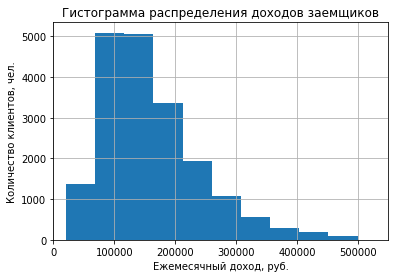

In [27]:
data[(data['total_income'] > 0) & (data['total_income'] < 500000)]['total_income'].hist()
plt.title('Гистограмма распределения доходов заемщиков')
plt.xlabel('Ежемесячный доход, руб.')
plt.ylabel('Количество клиентов, чел.')
plt.xlim(0, 550000);

Большинство заемщиков вполне платежеспособны. Распределение доходов близко к нормальному. Может быть, в столбце есть артефакты?

In [28]:
data['total_income'].max()

2265604

То, что может показаться артефактом, может быть просто очень хорошим доходом. :)

Проверим, нет ли странных значений в столбце с возрастом:

In [29]:
data.groupby('dob_years')['dob_years'].count()

dob_years
0     100
19     14
20     51
21    110
22    183
23    252
24    262
25    356
26    406
27    490
28    501
29    543
30    536
31    556
32    506
33    577
34    597
35    614
36    553
37    531
38    595
39    572
40    603
41    603
42    592
43    510
44    543
45    494
46    469
47    480
48    536
49    505
50    509
51    446
52    483
53    457
54    476
55    441
56    482
57    457
58    461
59    441
60    376
61    353
62    351
63    268
64    263
65    194
66    183
67    167
68     99
69     83
70     65
71     58
72     33
73      8
74      6
75      1
Name: dob_years, dtype: int64

У нас есть 100 человек, возраст которых неизвестен. Пока оставим эти данные без изменений, но будем иметь в виду.

С артефактами в столбце с трудовым стажем мы столкнулись еще при первичном обзоре данных. Посмотрим, сколько всего в столбце таких странных значений:

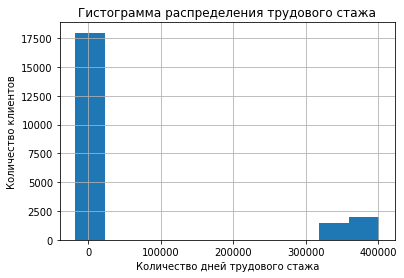

In [30]:
data['days_employed'].hist()
plt.title('Гистограмма распределения трудового стажа')
plt.xlabel('Количество дней трудового стажа')
plt.ylabel('Количество клиентов');

Кажется, значения трудового стажа были нормализованы: в столбце days_employed отражен не абсолютный стаж в днях, а отклонения от среднего или медианного значения. 

В таком случае, понятно, откуда взялись отрицательные значения: если значение меньше нуля - значит, трудовой стаж заемщика меньше среднего. Вероятно, такой способ представления трудового стажа лучше подходит для кредитного скоринга.

И еще здесь довольно много артефактов - нереалистично больших значений (больше 300 000 дней - это больше 820 лет!). 

Можно предположить, что часть значений по ошибке указана в часах, а не днях. Если разделить 300 000 - 400 000 на 24, получим 34 - 45 лет. Проверим, соотносится ли это с возрастом заемщиков, и поймем, верна ли гипотеза:

In [31]:
work_times = data[(data['days_employed'] > 300000) & (data['dob_years'] != 0)][['days_employed', 'dob_years']]
work_times['years_employed'] = work_times['days_employed'] / 365 / 24
work_times['years_employed'] = work_times['years_employed'].astype('int')
work_times['diff'] = work_times['dob_years'] - work_times['years_employed']
len(work_times[work_times['diff'] < 16]) / len(work_times) * 100

30.785002929115407

В более чем 30% случаев разница между возрастом и трудовым стажем - менее 16 лет. Похоже, наша гипотеза неверна. Как поступить с артефактами в таком случае? Заменим их на усредненное значение. Осталось понять, на какое именно.

In [32]:
data['days_employed'].describe()

count     21401.000000
mean      56782.556189
std      134971.956744
min      -18388.000000
25%       -2516.000000
50%        -983.000000
75%           0.000000
max      401755.000000
Name: days_employed, dtype: float64

In [33]:
data[data['days_employed'] < 100000]['days_employed'].describe()

count    17970.000000
mean     -2070.042515
std       2293.116318
min     -18388.000000
25%      -2895.750000
50%      -1348.500000
75%       -449.000000
max          0.000000
Name: days_employed, dtype: float64

Значения в этом столбце нормализованы по 75% процентилю (если учитывать все данные) или по максимальному значению (если учитывать только верные данные). Заменим неправильные значения нулями, чтобы они заметно не влияли на дальнейшие выводы:

In [34]:
data.loc[data['days_employed'] > 100000, 'days_employed'] = 0
data[data['days_employed'] > 100000]['days_employed'].count()

0

## Категоризация<a id = 'categories'></a>

Добрались до самого интересного. Как разные характеристики заемщиков влияют на факт возврата кредита в срок? Для начала выясним, как часто банк сталкивается с невозвратами:

In [35]:
data.debt.value_counts(normalize = True)

0    0.919069
1    0.080931
Name: debt, dtype: float64

В среднем по нашему датасету 92% заемщиков возвратили кредит в срок, 8% не сделали этого. Посмотрим, меняется ли это соотношение в зависимости от интересующих нас переменных (семейного статуса и количества детей):

In [36]:
pd.crosstab(data.debt, data.family_status, normalize = 'columns')

family_status,в разводе,вдовец / вдова,гражданский брак,женат / замужем,не женат / не замужем
debt,,,,,
0,0.929352,0.933824,0.90743,0.924646,0.902465
1,0.070648,0.066176,0.09257,0.075354,0.097535


Самая низкая доля невозвратов - среди заемщиков с семейным статусом "вдовец/вдова", "в разводе". Самая высокая доля невозвратов - среди неженатых/незамужних и состоящих в гражданском браке. Но может быть, дело скорее в возрасте, чем в семейном статусе?

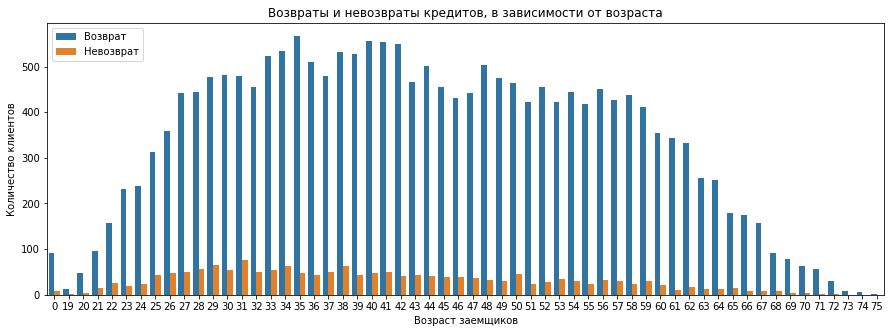

In [37]:
plt.figure(figsize=(15,5))
sns.countplot(x = 'dob_years', hue = 'debt', data = data)
plt.title('Возвраты и невозвраты кредитов, в зависимости от возраста')
plt.xlabel('Возраст заемщиков')
plt.ylabel('Количество клиентов')
plt.legend(['Возврат', 'Невозврат'])
plt.show()

Кажется, доля невозвратов у заемщиков в более молодом возрасте действительно выше, но на этом графике это неочевидно. Высчитаем долю невозвратов для разных возрастов:

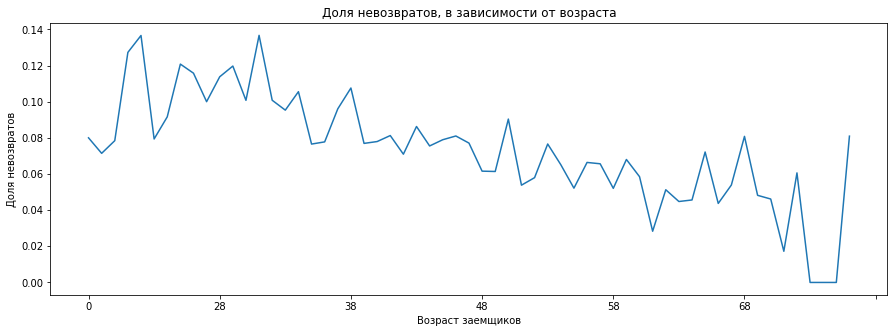

In [38]:
years_debts = pd.crosstab(data.dob_years, data.debt, margins = True)
years_debts['debt_perc'] = years_debts[1] / years_debts['All']
years_debts['debt_perc'].plot(figsize = (15, 5), title = 'Доля невозвратов, в зависимости от возраста')
plt.xlabel('Возраст заемщиков')
plt.ylabel('Доля невозвратов')
plt.show()

Заметна явная отрицательная корреляция между возрастом и долей невозвратов. Судя по графику, у заемщиков старше 38 лет доля невозвратов заметно ниже. Посмотрим, на сколько:

In [39]:
def age_group(age):
    if age <= 38:
        return '38-'
    else:
        return '38+'
data['age_group'] = data['dob_years'].apply(age_group)
age_debt = data.groupby('age_group').debt.agg(['sum', 'count']).reset_index()
age_debt['age_perc'] = age_debt['sum'] / age_debt['count']
age_debt

,age_group,sum,count,age_perc
0,38+,871,13068,0.066651
1,38-,861,8333,0.103324


Среди заемщиков в возрасте старше 38 лет доля невозвратов составляет 0,066, а среди заемщиков моложе 38 лет - 0,103. Разница значительная.

Теперь выясним, связано ли количество детей у заемщика с вероятностью возврата кредита в срок:

In [40]:
pd.crosstab(data.debt, data.children, normalize = 'columns')

children,0,1,2,3,4,5
debt,,,,,,
0,0.924866,0.907846,0.905596,0.918182,0.902439,1.0
1,0.075134,0.092154,0.094404,0.081818,0.097561,0.0


Здесь тоже заметна тенденция: больше детей - выше доля невозвратов. 

Но нельзя сказать, что количество детей влияет на вероятность возврата кредита. Может быть, количество детей коррелирует с другим фактором, который влияет на вероятность возврата кредита?

Посмотрим, как шансы на возврат кредита зависят от уровня образования клиентов:

In [42]:
pd.crosstab(data['education'], data['debt'], normalize = 'index')

debt,0,1
education,,
высшее,0.946916,0.053084
начальное,0.890071,0.109929
неоконченное высшее,0.908108,0.091892
среднее,0.910478,0.089522
ученая степень,1.000000,0.000000


In [58]:
data[(data['education'] != 'высшее') & (data['education'] != 'ученая степень')]['debt'].value_counts(normalize = True)

0    0.910014
1    0.089986
Name: debt, dtype: float64

In [59]:
data[(data['education'] == 'высшее') | (data['education'] == 'ученая степень')]['debt'].value_counts(normalize = True)

0    0.946977
1    0.053023
Name: debt, dtype: float64

Заемщики с высшим образованием или ученой степенью не возвращают кредиты в 5.3% случаев. Среди клиентов с более низким уровнем образования процент невозвратов значительно выше: почти 9%.

# Выводы<a id = 'summary'></a>

**В среднем, 8% заемщиков не возвращают кредит в срок.** 

Как ни удивительно, вероятность возврата банковского кредита очень слабо коррелирует с *уровнем дохода заемщика* и *целью кредита*. Значимой корреляции с *семейным статусом* и *количеством детей* также не обнаружено.

Зато есть заметная положительная корреляция с *возрастом* и *уровнем образования*: чем старше человек и чем выше уровень его образования, тем выше шансы, что он отдаст кредит в срок:
- Среди заемщиков в возрасте старше 38 лет доля невозвратов составляет 6,7%, а среди заемщиков моложе 38 лет - 10,3%.
- Заемщики с высшим образованием не возвращают кредиты значительно реже, чем клиенты с более низким уровнем образования (5,3% против 9%).

**При разработке модели кредитного скоринга рекомендуется сделать акцент на таких параметрах, как возраст заемщика и уровень его образования**.

Сотрудникам банка заказчика рекомендуется найти технические или человеческие ошибки, которые приводят к появлению пропусков и неверных значений, чтобы избежать появления этих ошибок в будущем:
- 10% данных в столбцах с трудовым стажем и уровнем дохода пропущено;
- около 16% значений в столбце с трудовым стажем - неверные;
- также есть незначительное количество ошибок в столбцах с возрастом заемщиков и количеством детей;
- рекомендуется уточнить, какой род занятий подразумевается под значением "компаньон" в столбце 'income_type', во избежание ошибок при анализе данных и разработке модели кредитного скоринга.